<a href="https://www.kaggle.com/code/kapusharinka/spam-ham-emails?scriptVersionId=125942218" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeSpamAssassin.csv
/kaggle/input/corpora/corpora/wordnet/data.adj
/kaggle/input/corpora/corpora/wordnet/LICENSE
/kaggle/input/corpora/corpora/wordnet/index.adj
/kaggle/input/corpora/corpora/wordnet/README
/kaggle/input/corpora/corpora/wordnet/verb.exc
/kaggle/input/corpora/corpora/wordnet/index.adv
/kaggle/input/corpora/corpora/wordnet/index.verb
/kaggle/input/corpora/corpora/wordnet/data.verb
/kaggle/input/corpora/corpora/wordnet/lexnames
/kaggle/input/corpora/corpora/wordnet/data.noun
/kaggle/input/corpora/corpora/wordnet/noun.exc
/kaggle/input/corpora/corpora/wordnet/index.noun
/kaggle/input/corpora/corpora/wordnet/adj.exc
/kaggle/input/corpora/corpora/wordnet/index.sense
/kaggle/input/corpora/corpora/wordnet/adv.exc
/kaggle/input/corpora/corpora/wordnet/cntlist.rev
/kaggle/input/corpora/corpora/wordnet/data.adv
/kaggle/input/corpora/corpora/wordn

In [2]:
data1 = pd.read_csv('/kaggle/input/email-spam-dataset/lingSpam.csv')
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2605 non-null   int64 
 1   Body        2605 non-null   object
 2   Label       2605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.2+ KB


,Unnamed: 0,Body,Label
0,0,Subject: great part-time or summer job !\n \n ...,1
1,1,Subject: auto insurance rates too high ?\n \n ...,1
2,2,Subject: do want the best and economical hunti...,1
3,3,Subject: email 57 million people for $ 99\n \n...,1
4,4,Subject: do n't miss these !\n \n attention ! ...,1


In [3]:
data2 = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10000 non-null  int64 
 1   Unnamed: 0.1  10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [4]:
data3 = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')
data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
# delete unneeded columns
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

In [6]:
# concatenate data
data = pd.concat([data1,data2,data3],axis=0)
# remove missing values (NaN)
data.dropna(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    18650 non-null  object
 1   Label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


# Text preprocessing

In [7]:
emails = data["Body"]

In [8]:
# lowering case
emails = [text.lower() for text in emails]
emails[0]

'subject: great part-time or summer job !\n \n * * * * * * * * * * * * * * * we have display boxes with credit applications that we need to place in the small owner-operated stores in your area . here is what you do : 1 . introduce yourself to the store owner or manager . 2 . use our 90 % effective script which tells them how this little display box will save their customers hundreds of dollars , be a drawing card for their business , and make them from $ 5 . 00 to $ 15 . 00 or more for every app sent in . 3 . find a good spot on the counter , place the box there , and say that nothing more need be done , all you need is his name and address so the company can send him the commission checks . your compensaation will be $ 10 for every box you place . by becoming a representative you could also earn a commission of $ 10 for each application that came from that store . that is of course a much more profitable plan , as it will pay you for months or years for a very small effort . call 1-8

In [9]:
# removal of special characters and numbers
import re
emails = [re.sub("[^a-zA-Z]"," ",text) for text in emails]
emails[0]

'subject  great part time or summer job                                    we have display boxes with credit applications that we need to place in the small owner operated stores in your area   here is what you do       introduce yourself to the store owner or manager       use our      effective script which tells them how this little display box will save their customers hundreds of dollars   be a drawing card for their business   and make them from          to           or more for every app sent in       find a good spot on the counter   place the box there   and say that nothing more need be done   all you need is his name and address so the company can send him the commission checks   your compensaation will be      for every box you place   by becoming a representative you could also earn a commission of      for each application that came from that store   that is of course a much more profitable plan   as it will pay you for months or years for a very small effort   call      

In [10]:
# removal of extra spaces
emails = [re.sub(" +", " ", text) for text in emails]
emails[0]

'subject great part time or summer job we have display boxes with credit applications that we need to place in the small owner operated stores in your area here is what you do introduce yourself to the store owner or manager use our effective script which tells them how this little display box will save their customers hundreds of dollars be a drawing card for their business and make them from to or more for every app sent in find a good spot on the counter place the box there and say that nothing more need be done all you need is his name and address so the company can send him the commission checks your compensaation will be for every box you place by becoming a representative you could also earn a commission of for each application that came from that store that is of course a much more profitable plan as it will pay you for months or years for a very small effort call code hours to receive the details to be removed from our mailing list type b hotmail com in the to area and remove 

In [11]:
# removal of hyperlinks
emails = [re.sub(r"http\S+", "", text) for text in emails]

# removal of HTML tags
emails = [re.sub(r"'<.*?>'", "", text) for text in emails]
emails[0]

'subject great part time or summer job we have display boxes with credit applications that we need to place in the small owner operated stores in your area here is what you do introduce yourself to the store owner or manager use our effective script which tells them how this little display box will save their customers hundreds of dollars be a drawing card for their business and make them from to or more for every app sent in find a good spot on the counter place the box there and say that nothing more need be done all you need is his name and address so the company can send him the commission checks your compensaation will be for every box you place by becoming a representative you could also earn a commission of for each application that came from that store that is of course a much more profitable plan as it will pay you for months or years for a very small effort call code hours to receive the details to be removed from our mailing list type b hotmail com in the to area and remove 

In [12]:
# tokenization
import nltk
emails = [nltk.word_tokenize(text) for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'or',
 'summer',
 'job',
 'we',
 'have',
 'display',
 'boxes',
 'with',
 'credit',
 'applications',
 'that',
 'we',
 'need',
 'to',
 'place',
 'in',
 'the',
 'small',
 'owner',
 'operated',
 'stores',
 'in',
 'your',
 'area',
 'here',
 'is',
 'what',
 'you',
 'do',
 'introduce',
 'yourself',
 'to',
 'the',
 'store',
 'owner',
 'or',
 'manager',
 'use',
 'our',
 'effective',
 'script',
 'which',
 'tells',
 'them',
 'how',
 'this',
 'little',
 'display',
 'box',
 'will',
 'save',
 'their',
 'customers',
 'hundreds',
 'of',
 'dollars',
 'be',
 'a',
 'drawing',
 'card',
 'for',
 'their',
 'business',
 'and',
 'make',
 'them',
 'from',
 'to',
 'or',
 'more',
 'for',
 'every',
 'app',
 'sent',
 'in',
 'find',
 'a',
 'good',
 'spot',
 'on',
 'the',
 'counter',
 'place',
 'the',
 'box',
 'there',
 'and',
 'say',
 'that',
 'nothing',
 'more',
 'need',
 'be',
 'done',
 'all',
 'you',
 'need',
 'is',
 'his',
 'name',
 'and',
 'address',
 'so',
 'the',
 'co

In [13]:
# removal of stopwords
stopwords = nltk.corpus.stopwords.words("english")
emails = [[word for word in text if word not in stopwords] for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'summer',
 'job',
 'display',
 'boxes',
 'credit',
 'applications',
 'need',
 'place',
 'small',
 'owner',
 'operated',
 'stores',
 'area',
 'introduce',
 'store',
 'owner',
 'manager',
 'use',
 'effective',
 'script',
 'tells',
 'little',
 'display',
 'box',
 'save',
 'customers',
 'hundreds',
 'dollars',
 'drawing',
 'card',
 'business',
 'make',
 'every',
 'app',
 'sent',
 'find',
 'good',
 'spot',
 'counter',
 'place',
 'box',
 'say',
 'nothing',
 'need',
 'done',
 'need',
 'name',
 'address',
 'company',
 'send',
 'commission',
 'checks',
 'compensaation',
 'every',
 'box',
 'place',
 'becoming',
 'representative',
 'could',
 'also',
 'earn',
 'commission',
 'application',
 'came',
 'store',
 'course',
 'much',
 'profitable',
 'plan',
 'pay',
 'months',
 'years',
 'small',
 'effort',
 'call',
 'code',
 'hours',
 'receive',
 'details',
 'removed',
 'mailing',
 'list',
 'type',
 'b',
 'hotmail',
 'com',
 'area',
 'remove',
 'subject',
 'area'

Stemming or lemmatization - lemmatizators are slower, but change tenses and nouns. Use the Wordnet lemmatizer, but with POS tag) 

In [14]:
# lemmatization
nltk.data.path.append('/kaggle/input/corpora/')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
emails = [[lemmatizer.lemmatize(word) for word in text] for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'summer',
 'job',
 'display',
 'box',
 'credit',
 'application',
 'need',
 'place',
 'small',
 'owner',
 'operated',
 'store',
 'area',
 'introduce',
 'store',
 'owner',
 'manager',
 'use',
 'effective',
 'script',
 'tell',
 'little',
 'display',
 'box',
 'save',
 'customer',
 'hundred',
 'dollar',
 'drawing',
 'card',
 'business',
 'make',
 'every',
 'app',
 'sent',
 'find',
 'good',
 'spot',
 'counter',
 'place',
 'box',
 'say',
 'nothing',
 'need',
 'done',
 'need',
 'name',
 'address',
 'company',
 'send',
 'commission',
 'check',
 'compensaation',
 'every',
 'box',
 'place',
 'becoming',
 'representative',
 'could',
 'also',
 'earn',
 'commission',
 'application',
 'came',
 'store',
 'course',
 'much',
 'profitable',
 'plan',
 'pay',
 'month',
 'year',
 'small',
 'effort',
 'call',
 'code',
 'hour',
 'receive',
 'detail',
 'removed',
 'mailing',
 'list',
 'type',
 'b',
 'hotmail',
 'com',
 'area',
 'remove',
 'subject',
 'area',
 'new',
 'e

# Feature extraction 
Creating a vector of features (words) for each email

OpenAI:
> Both CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency) from scikit-learn are popular techniques for feature extraction in text data like emails, and each has its own merits.
> 
> CountVectorizer creates a Bag of Words (BoW) model, where the features are the counts of each word in the document. This method is simple and easy to implement but can give more importance to words that appear frequently, regardless of their significance in distinguishing spam from non-spam emails.
> 
> TF-IDF, on the other hand, takes into account not only the frequency of a word in a document but also its inverse frequency across all documents. This means that words that are common across all emails will receive lower weights, while words that are unique to specific emails will receive higher weights. This can be advantageous for spam detection, as spam emails often contain specific words or phrases that are less common in legitimate emails.
> 
> In general, TF-IDF tends to work better than CountVectorizer for spam detection because it can better capture the importance of different words. However, the choice between the two methods will depend on the specific characteristics of the dataset and the problem you're trying to solve. It's a good idea to experiment with both techniques and evaluate their performance on your dataset using cross-validation or a separate validation set. This will help you determine which method works best for your particular spam detection task.

In [15]:
# Bag of Words, almost all preprocessing steps could be done there
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=25000)
x = vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(x.shape)
vectorizer.get_feature_names_out()[:10] # first 10 in alphabetical order

(18650, 25000)


array(['aa', 'aaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
       'aaai', 'aaal', 'aace', 'aachen', 'aadhv', 'aal', 'aalborg'],
      dtype=object)

In [16]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(max_features=25000)
x2 = tf_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(x2.shape)
tf_vectorizer.get_feature_names_out()[:10]

(18650, 25000)


array(['aa', 'aaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
       'aaai', 'aaal', 'aace', 'aachen', 'aadhv', 'aal', 'aalborg'],
      dtype=object)

# Word cloud

In [17]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from PIL import Image

# spam_emails = np.vstack((np.asarray(emails), np.asarray(data["Label"])))
# spam_emails[0]                        

# spams = ' '.join([' '.join(email) for email in emails])

# #create the wordcloud object
# wordcloud = WordCloud(stopwords = STOPWORDS, collocations=True).generate(spams)

# #plot the wordcloud object
# plt.imshow(wordcloud, interpolation='bilInear')
# plt.axis('off')
# plt.show()

In [18]:
# # create a dictionary of word frequencies
# text_dictionary = wordcloud.process_text(whole_text)
# # sort the dictionary
# word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

# #use words_ to print relative word frequencies
# rel_freq=wordcloud.words_

# #print results
# print(list(word_freq.items())[:5])
# print(list(rel_freq.items())[:5])

In [19]:
# word cloud with the most frequent words
# TF-IDF, TF-IDF weighted W2V, and average W2
# try creating a length of text feature and average word length and find whether it’s practical
# LDA for topic modeling as a feature

# Split to train and test data

In [20]:
# split to train and test data for CountVectorizer
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, np.asarray(data["Label"]), random_state=42, test_size=0.2)
x_train.shape

(14920, 25000)

In [21]:
# split to train and test data for TF-IDF
x2_train,x2_test,y2_train,y2_test = train_test_split(x2, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# Classification algorithms (supervised)
( https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2 )

## Evaluation metrics:
**Accuracy** = (True Positives + True Negatives) / (True Positives + False Positives + True Negatives + False Negatives) <br />
Accuracy measures the proportion of correct predictions made by the model out of the total number of predictions.


**Precision** = True Positives / (True Positives + False Positives) <br />
Precision measures the proportion of true positive predictions out of all the positive predictions made by the model.


**Recall** = True Positives / (True Positives + False Negatives) <br />
In the context of spam detection, recall indicates how well the classifier identifies spam emails out of all the actual spam emails.


**F1 Score** = 2 * (Precision * Recall) / (Precision + Recall) <br />
An F1 score reaches its best value at 1 (perfect precision and recall) and its worst value at 0.

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn
import matplotlib.pyplot as plt

def print_stats(algorithm, x_train_data, x_test_data, y_train_data, y_test_data): 
    
    # actually perform classification
    y_pred = algorithm.predict(x_test_data) 

    # Thus in binary classification, the count of 
    # true negatives is 0,0 
    # false negatives is 1,0
    # true positives is 1,1
    # false positives is 0,1
    conf = confusion_matrix(y_pred=y_pred,y_true=y_test_data)
    
    tn, fp, fn, tp = conf.ravel()
    print("Accuracy on training data: {:.2f}%".format(100 * algorithm.score(x_train_data,y_train_data)))
    print("Accuracy on testing data: {:.2f}%".format(100 * algorithm.score(x_test_data,y_test_data)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_pred, y_test_data)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_pred, y_test_data)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_pred, y_test_data)))

    ax= plt.subplot()
    seaborn.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()

Using Count Vectorizer: 
Accuracy on training data: 87.76%
Accuracy on testing data: 83.38%
Precision: 92.76%
Recall: 72.54%
F1 Score: 81.41%


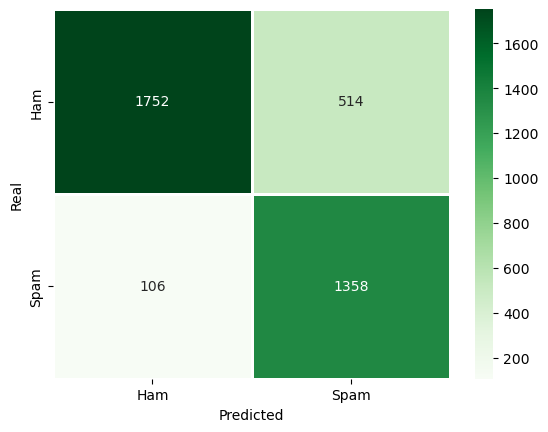

Using TF-IDF: 
Accuracy on training data: 95.98%
Accuracy on testing data: 90.21%
Precision: 87.23%
Recall: 87.77%
F1 Score: 87.50%


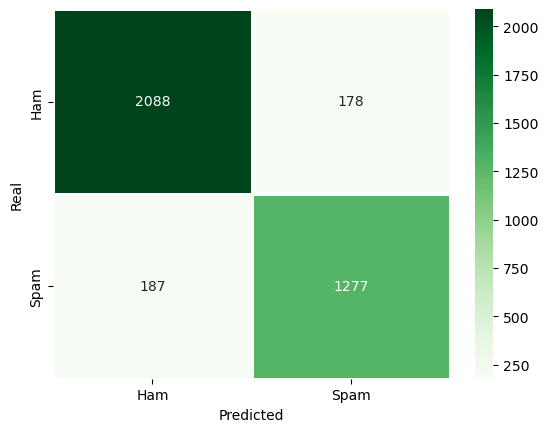

In [23]:
# Naïve Bayes
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(x_train,y_train)
print("Using Count Vectorizer: ")
print_stats(NB,x_train,x_test,y_train,y_test)

NB2 = GaussianNB()
NB2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(NB2,x2_train,x2_test,y2_train,y2_test)

Using Count Vectorizer: 
Accuracy on training data: 95.66%
Accuracy on testing data: 94.72%
Precision: 96.79%
Recall: 90.43%
F1 Score: 93.50%


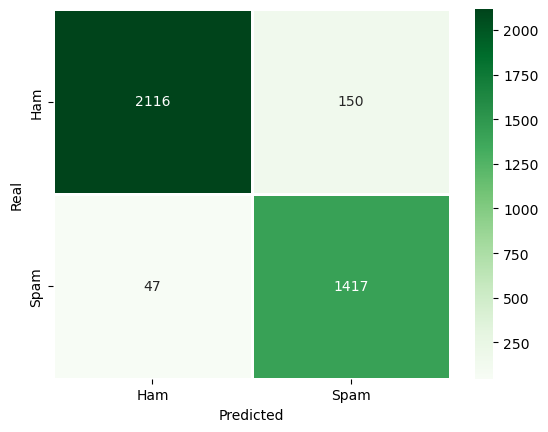

Using TF-IDF: 
Accuracy on training data: 96.98%
Accuracy on testing data: 95.90%
Precision: 94.13%
Recall: 95.36%
F1 Score: 94.74%


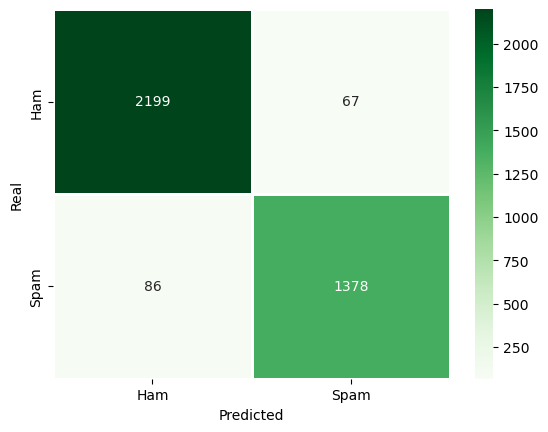

In [24]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(x_train,y_train)
print("Using Count Vectorizer: ")
print_stats(MNB,x_train,x_test,y_train,y_test)

MNB2 = MultinomialNB()
MNB2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(MNB2,x2_train,x2_test,y2_train,y2_test)

Using Count Vectorizer: 
Accuracy on training data: 98.85%
Accuracy on testing data: 96.70%
Precision: 97.88%
Recall: 93.97%
F1 Score: 95.88%


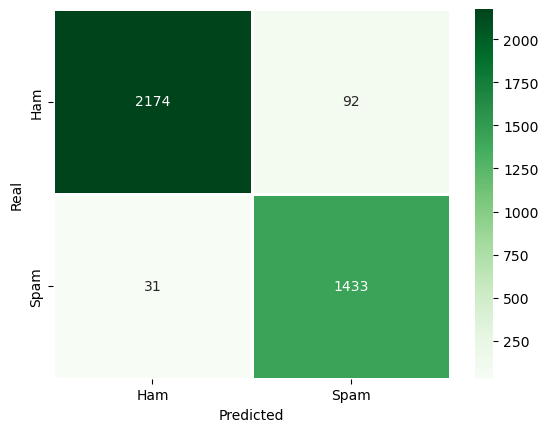

Using TF-IDF: 
Accuracy on training data: 98.02%
Accuracy on testing data: 96.76%
Precision: 96.58%
Recall: 95.22%
F1 Score: 95.90%


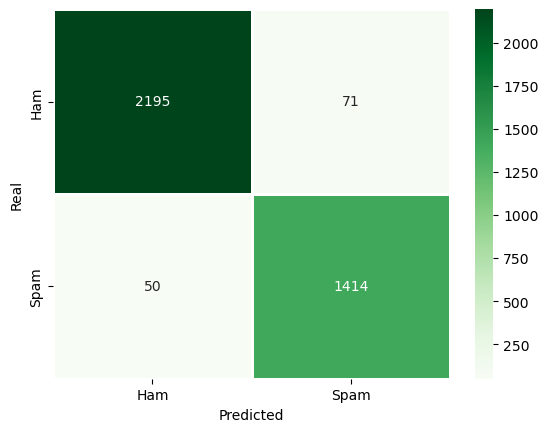

In [25]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1000)
LR.fit(x_train, y_train)
print("Using Count Vectorizer: ")
print_stats(LR,x_train,x_test,y_train,y_test)

LR2 = LogisticRegression(max_iter=1000)
LR2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(LR2,x2_train,x2_test,y2_train,y2_test)

In [26]:
# very long and not very accurate, 12 minutes
# from sklearn.neighbors import KNeighborsClassifier
# KNN = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
# KNN.fit(x_train, y_train)

# print_stats(KNN)

Using Count Vectorizer: 
Accuracy on training data: 94.99%
Accuracy on testing data: 94.37%
Precision: 90.37%
Recall: 95.04%
F1 Score: 92.65%


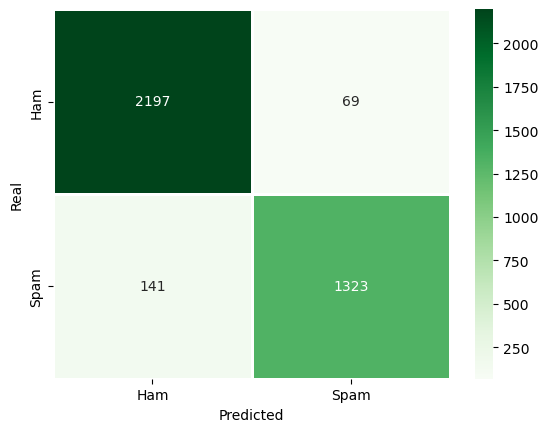

Using TF-IDF: 
Accuracy on training data: 98.93%
Accuracy on testing data: 97.05%
Precision: 97.88%
Recall: 94.78%
F1 Score: 96.30%


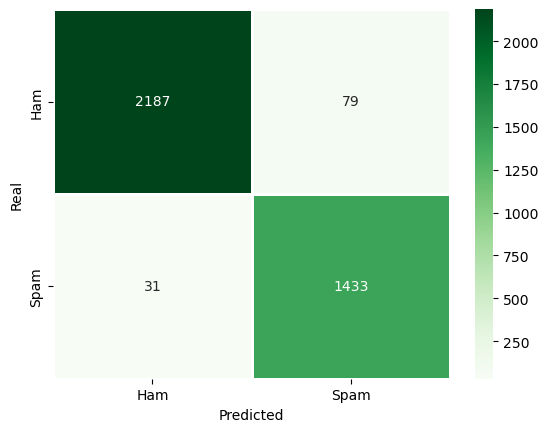

In [27]:
from sklearn.svm import LinearSVC
SVM = LinearSVC(C=0.0001)
SVM.fit(x_train, y_train)
print("Using Count Vectorizer: ")
print_stats(SVM,x_train,x_test,y_train,y_test)

SVM2 = LinearSVC(C=10)
SVM2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(SVM2,x2_train,x2_test,y2_train,y2_test)

In [28]:
# 4 minutes
# from sklearn.tree import DecisionTreeClassifier
# CLF = DecisionTreeClassifier()
# CLF.fit(x_train, y_train)

# print_stats(CLF)

Using Count Vectorizer: 
Accuracy on training data: 98.28%
Accuracy on testing data: 96.03%
Precision: 95.90%
Recall: 94.10%
F1 Score: 94.99%


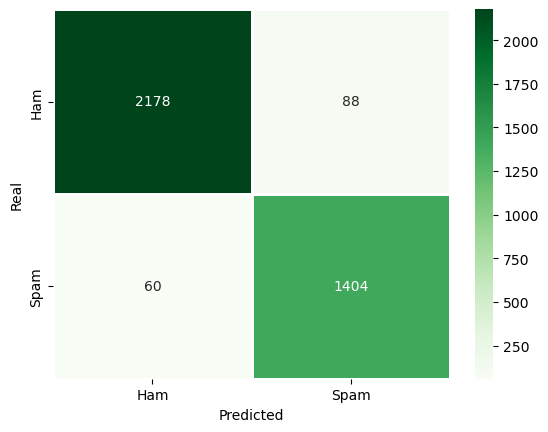

Using TF-IDF: 
Accuracy on training data: 98.45%
Accuracy on testing data: 96.14%
Precision: 95.56%
Recall: 94.65%
F1 Score: 95.11%


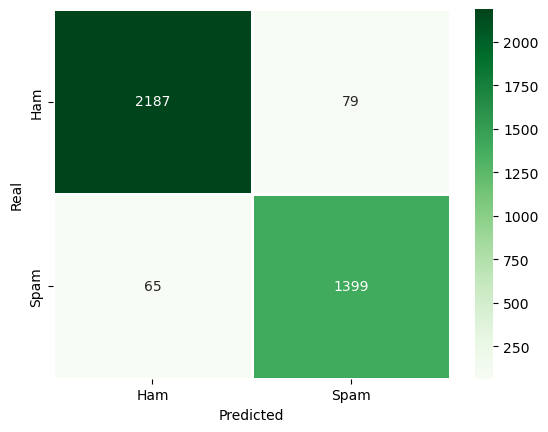

In [29]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
RF = RandomForestClassifier(n_estimators=100, max_depth=50)
RF.fit(x_train, y_train)
print("Using Count Vectorizer: ")
print_stats(RF,x_train,x_test,y_train,y_test)

RF2 = RandomForestClassifier(n_estimators=100, max_depth=50)
RF2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(RF2,x2_train,x2_test,y2_train,y2_test)

Using Count Vectorizer: 
Accuracy on training data: 98.34%
Accuracy on testing data: 96.57%
Precision: 96.45%
Recall: 94.89%
F1 Score: 95.66%


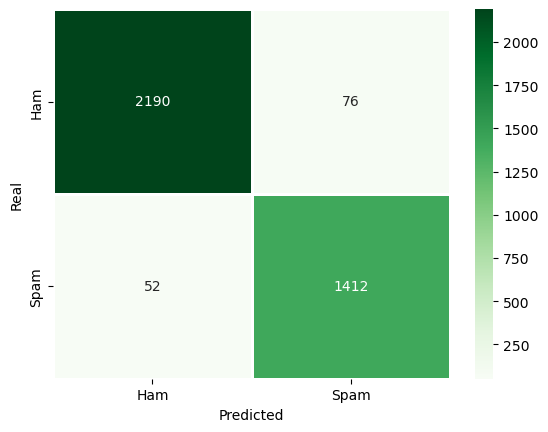

Using TF-IDF: 
Accuracy on training data: 98.44%
Accuracy on testing data: 96.73%
Precision: 95.70%
Recall: 95.96%
F1 Score: 95.83%


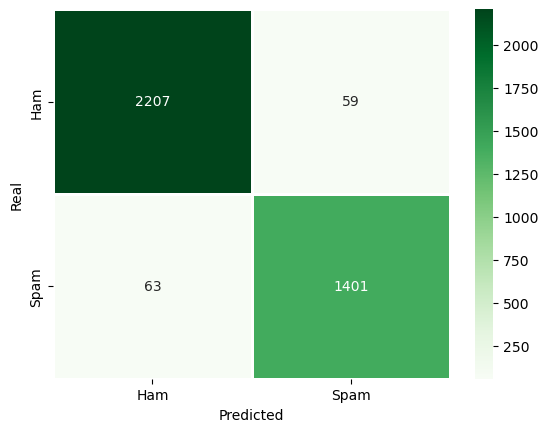

In [30]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
EVC = VotingClassifier(estimators=[('MNB',MNB),('LR',LR),('RF',RF),('SVM',SVM)], voting='hard')
EVC.fit(x_train, y_train)
print("Using Count Vectorizer: ")
print_stats(EVC,x_train,x_test,y_train,y_test)

EVC2 = VotingClassifier(estimators=[('MNB',MNB2),('LR',LR2),('RF',RF2),('SVM',SVM2)], voting='hard')
EVC2.fit(x2_train,y2_train)
print("Using TF-IDF: ")
print_stats(EVC2,x2_train,x2_test,y2_train,y2_test)

# Unsupervised algorithms 
## Topic modelling
https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
https://towardsdatascience.com/the-ultimate-guide-to-clustering-algorithms-and-topic-modeling-3a65129df324

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=2, random_state=42)
LDA.fit(x2)

LatentDirichletAllocation(n_components=2, random_state=42)

In [32]:
# Explore the topics
for topic_idx, topic in enumerate(LDA.components_):
    print(f"Topic {topic_idx + 1}:")
    top_n_words = 10
    feature_names = tf_vectorizer.get_feature_names_out()
    top_words = [feature_names[i] for i in topic.argsort()[-top_n_words:]]
    print(" ".join(top_words))

Topic 1:
schedule gas deal hou ie linux subject ect enron empty
Topic 2:
free net get subject click email www list http com


## Clustering
https://stackoverflow.com/a/69024239 <br/>
https://stackoverflow.com/a/27586132

In [33]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

def print_stats_for_unsupervised(algorithm, x_data): 
    
    y_pred = algorithm.fit_predict(x_data) 
    conf = confusion_matrix(y_pred=y_pred,y_true=np.asarray(data["Label"]))

    # tn, fp, fn, tp = conf.ravel()
    # print("Accuracy on data: {:.2f}%".format(100 * algorithm.score(x2,np.asarray(data["Label"]))))
    print("Precision: {:.2f}%".format(100 * precision_score(y_pred, np.asarray(data["Label"]))))
    print("Recall: {:.2f}%".format(100 * recall_score(y_pred, np.asarray(data["Label"]))))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_pred, np.asarray(data["Label"]))))
    print("Davies-Bouldin score: {:.2f}%".format(100 * davies_bouldin_score(x_data, y_pred)))
    print("Silhouette score: {:.2f}%".format(100 * silhouette_score(x_data, y_pred)))

    ax=plt.subplot()
    seaborn.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()

Precision: 4.57%
Recall: 62.85%
F1 Score: 8.52%
Davies-Bouldin score: 6.21%
Silhouette score: 90.56%


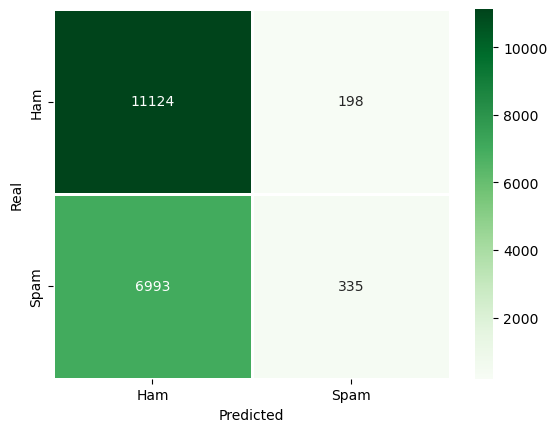

In [34]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(x2)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

KM = KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=42)
print_stats_for_unsupervised(KM, pca_vecs)


Cluster 0
attached,right,first,product,html,cc,change,phone,question,credit,find,schedule,de,contact,today,good,gas,help,way,rpm,mailman,spamassassin,week,send,program,go,start,could,take,url,rate,home,sent,let,number,online,service,hour,report,vince,system,file,listinfo,mailing,also,pm,best,offer,name,people,deal,call,money,order,group,year,hou,site,university,use,user,make,software,work,want,see,may,thanks,address,price,business,ie,day,need,company,know,like,date,language,information,free,new,message,mail,would,time,one,net,linux,get,click,email,please,ect,www,list,enron,http,com,subject

Cluster 1
fiiings,flier,fined,finest,flaky,flake,flagship,flagged,flag,fla,fl,fj,fixture,flame,fixing,fix,five,fitzpatrick,fitzgerald,fitting,fitness,fitch,fit,fisting,fixed,flamer,flap,flash,flexible,flexibility,flexeril,flex,flew,fletcher,flesh,flemish,fleming,fleischer,flege,fleet,fled,flb,flawed,flaw,flavour,flavor,flatiron,flat,flashed,fist,finer,fishman,fisherman,firbas,fiorina,fiorida,fioric

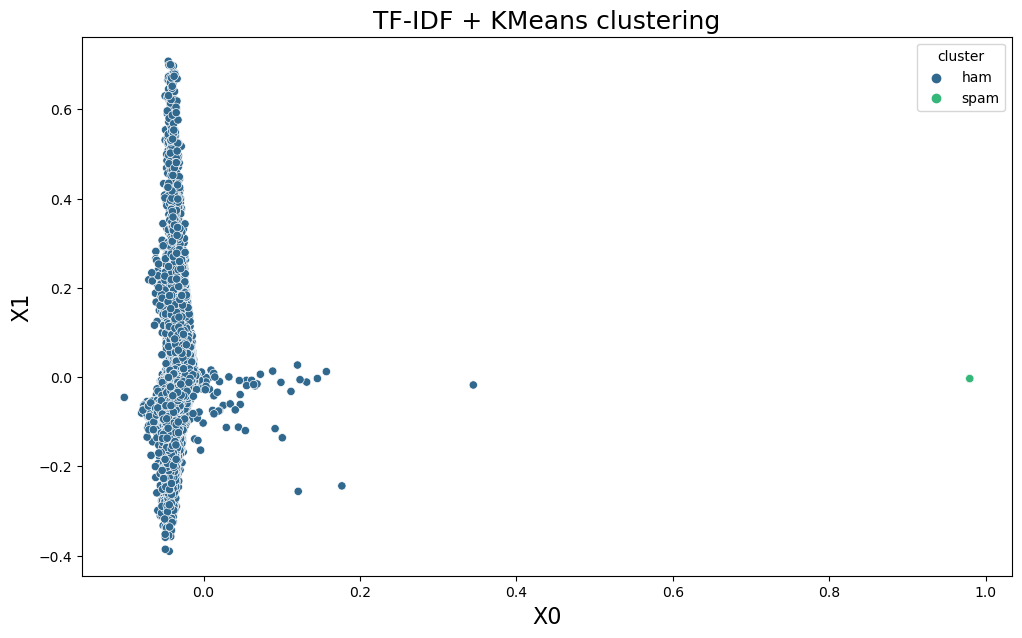

In [35]:
# assign clusters and pca vectors to our dataframe 
clusters = KM.labels_
data['cluster'] = clusters
data['x0'] = x0
data['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    data = pd.DataFrame(x2).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = tf_vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in data.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(100)

# map clusters to appropriate labels 
cluster_map = {0: "ham", 1: "spam"}
# apply mapping
data['cluster'] = data['cluster'].map(cluster_map)

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
seaborn.scatterplot(data=data, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [36]:
# very long
# from sklearn.cluster import DBSCAN
# DB = DBSCAN(eps=3, min_samples=2)
# print_stats_for_unsupervised(DB, x2)

In [37]:
# very very very long
# from sklearn.cluster import AgglomerativeClustering
# AC = AgglomerativeClustering()
# print_stats_for_unsupervised(AC, x2)

In [38]:
# from sklearn.cluster import SpectralClustering
# SC = SpectralClustering(n_clusters=2,assign_labels='discretize',random_state=0)
# print_stats_for_unsupervised(SC, x2)

## Anomaly detection

In [39]:
# very long
# from sklearn.ensemble import IsolationForest
# IF = IsolationForest(random_state=0)
# print_stats_for_unsupervised(IF, x2)

In [40]:
# from sklearn.neighbors import LocalOutlierFactor
# LOF = LocalOutlierFactor(n_neighbors=2)
# print_stats_for_unsupervised(LOF, x2)

In [41]:
# very very very very long
# from sklearn.svm import OneClassSVM
# OCSVM = OneClassSVM(gamma='auto')
# print_stats_for_unsupervised(OCSVM, x2)

# Deep learning algorithms
(subset of neural network algorithms)
## Supervised Learning

In [42]:
# CNN

In [43]:
# RNN

In [44]:
# LTSM

Transformer models: Transformers are a more recent innovation in NLP and have achieved state-of-the-art performance on various text classification tasks. The transformer architecture is based on self-attention mechanisms, allowing the model to efficiently capture context and dependencies in text. BERT, GPT, and RoBERTa are examples of transformer models that can be fine-tuned for spam detection.

In [45]:
# GPT

## Unsupervised Learning
While unsupervised deep learning algorithms can help learn useful representations of the data, they typically need to be combined with a supervised classifier or clustering algorithm to perform the actual spam detection. For instance, you could use an autoencoder to learn a low-dimensional representation of the email data and then train a supervised classifier (e.g., logistic regression, SVM) on the extracted features to classify emails as spam or ham.

### Autoencoder

In [46]:
# from keras.layers import Input, Dense
# from keras.models import Model

# input_dim = x2.shape[1]
# encoding_dim = 64  # The dimensionality of the latent space

# # Define the encoder
# input_data = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu')(input_data)

# # Define the decoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Create the autoencoder model
# autoencoder = Model(input_data, decoded)

# # Create the encoder model
# encoder = Model(input_data, encoded)

# # Compile and train the autoencoder
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.fit(x2, x2, epochs=50, batch_size=256, shuffle=True, 
#                 validation_data=(np.asarray(data["Label"]), np.asarray(data["Label"])))